# First itteration of QR decomposition algo. 

Only works on real unitaries.

[[ 0.354  0.354  0.354  0.354  0.354  0.354  0.354  0.354]
 [ 0.354 -0.354  0.354 -0.354  0.354 -0.354  0.354 -0.354]
 [ 0.354  0.354 -0.354 -0.354  0.354  0.354 -0.354 -0.354]
 [ 0.354 -0.354 -0.354  0.354  0.354 -0.354 -0.354  0.354]
 [ 0.354  0.354  0.354  0.354 -0.354 -0.354 -0.354 -0.354]
 [ 0.354 -0.354  0.354 -0.354 -0.354  0.354 -0.354  0.354]
 [ 0.354  0.354 -0.354 -0.354 -0.354 -0.354  0.354  0.354]
 [ 0.354 -0.354 -0.354  0.354 -0.354  0.354  0.354 -0.354]]


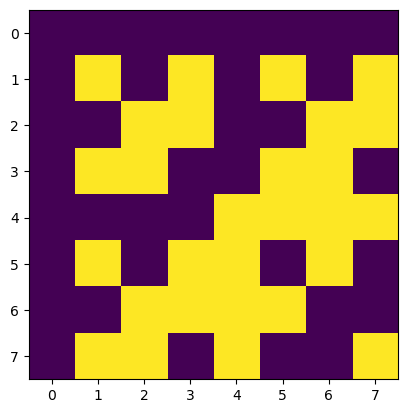

____________________________This works_____________________________________ 40
couplings =  [(0, 7), (0, 6), (0, 5), (0, 4), (0, 3), (0, 2), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 1), (0, 2), (0, 7), (0, 6), (0, 5), (0, 4), (0, 3), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 3), (0, 4), (0, 7), (0, 6), (0, 5), (0, 4), (0, 5), (0, 6), (0, 7), (0, 5), (0, 6), (0, 7), (0, 6), (0, 0)]
fractions =  [0.5, 0.3918265520306073, 0.33333333333333326, 0.2951672353008666, 0.26772047280122996, 0.24675171442884994, 1.230053456162616, 1.5456289483429901, 0.41956937674483386, 0.2951672353008666, 0.33333333333333337, 0.2163468959387855, 0.33333333333333337, 1.0, 1.0, 1.0, 0.2163468959387855, 0.33333333333333337, 0.2951672353008666, 0.41956937674483386, 1.0, 1.0, 0.5640942168489749, 0.5, 0.49999999999999983, 0.3918265520306073, 1.0, 1.0, 1.3918265520306072, 0.28043779800754365, 0.18642949867733732, 1.0, 1.0, 1.2142925045679323, 0.2677204728012301, 1.0, 1.0, 1.7048327646991335

In [48]:
import numpy as np
from numpy.linalg import norm

def detect_adjacent_same_couplings(rotation_mats, tol=1e-8):

    matches = []
    for U1, U2 in zip(rotation_mats[:-1], rotation_mats[1:]):
        # Find which level (other than 0) this pulse couples with
        def find_coupled_level(U):
            for j in range(1, U.shape[0]):
                if np.abs(U[0, j]) > tol or np.abs(U[j, 0]) > tol:
                    return j
            return None

        j1 = find_coupled_level(U1)
        j2 = find_coupled_level(U2)

        matches.append(int(j1 == j2 and j1 is not None))

    return matches

def compress_rotations(rotation_mats, tol=1e-8):
    i = 0
    optimized = []
    while i < len(rotation_mats):
        if i + 1 < len(rotation_mats):
            U1 = rotation_mats[i]
            U2 = rotation_mats[i+1]

            # Check if both couple the same (0, j)
            def find_coupled(U):
                for j in range(1, U.shape[0]):
                    if np.abs(U[0, j]) > tol or np.abs(U[j, 0]) > tol:
                        return j
                return None

            j1 = find_coupled(U1)
            j2 = find_coupled(U2)

            if j1 == j2 and j1 is not None:
                combined = U2 @ U1  # Order matters!
                if norm(combined - np.eye(U1.shape[0])) < tol:
                    # Cancels out → skip both
                    i += 2
                    continue
                else:
                    # Replace with combined
                    optimized.append(combined)
                    i += 2
                    continue

        # Default: keep current
        optimized.append(rotation_mats[i])
        i += 1

    return optimized

import numpy as np
from numpy.linalg import norm
from math import acos, pi

def inverse_single_pulse(U, *, tol= 1e-8):

    U = np.asarray(U)
    dim = U.shape[0]

    cand = [(p, q) for p in range(dim) for q in range(p+1, dim)
            if abs(U[p, q]) > tol or abs(U[q, p]) > tol]

    if len(cand) != 1:
        return (0,0), 0, 0

    i, j = cand[0]

    # everything outside rows/cols i,j must look like the identity
    mask = np.ones_like(U, dtype=bool)
    mask[[i, j], :] = False
    mask[:, [i, j]] = False
    if norm(U[mask] - np.eye(dim)[mask]) > tol:
        raise ValueError("Extra couplings detected – not a single pulse.")

    c = U[i, i].real        
    if abs(U[j, j].real - c) > tol or abs(U[i, i].imag) > tol or abs(U[j, j].imag) > tol:
        raise ValueError("Diagonal elements are inconsistent with a single pulse.")

    # numerical safety
    c = max(min(c, 1.0), -1.0)
    theta = 2 * acos(c)       # θ  (0 ≤ θ ≤ 2π)
    fraction = theta / pi

    u_ij = U[i, j]
    if abs(u_ij) < tol:
        raise ValueError("Zero off‑diagonal element – ambiguous phase.")
    phi = (np.angle(u_ij) + pi/2) % (2*pi)   

    return (i, j), fraction, phi

def givens_rotation(m, j, theta):

    G = np.eye(m)
    c = np.cos(theta)
    s = np.sin(theta)
    G[0, 0] = c
    G[0, j] = s
    G[j, 0] = -s
    G[j, j] = c
    return G

def star_qr_decomposition(order, U, tol=1e-10):
    
    m = U.shape[0]
    rotations_info = []  
    rotation_mats = []     
    V = U.copy()          
    

    col = 0
    count = 0
    for i in order[::-1]:#range(m-1, 0,-1):
        a = V[0, col]
        b = V[i, col]
        if np.abs(b) < tol:
            continue
        theta = np.arctan2(b, a)
        G = givens_rotation(m, i, theta)
        V = G @ V
        rotations_info.append(("rotate", i, theta, col))
        rotation_mats.append(G)
    

    for col in order:#range(1, m):
        theta_swap = np.pi / 2
        G_swap = givens_rotation(m, col, theta_swap)
        V = G_swap @ V
        rotations_info.append(("swap", col, theta_swap, col))
        rotation_mats.append(G_swap)
        count += 1 
        if count % 2 == 0:
            for i in order[count:][::-1]:#range(1, m):
                a = V[0, col]
                b = V[i, col]
                if np.abs(b) < tol:
                    continue
                theta = np.arctan2(b, a)
                G = givens_rotation(m, i, theta)
                V = G @ V
                rotations_info.append(("rotate", i, theta, col))
                rotation_mats.append(G)
    
            V = G_swap @ V   
            rotations_info.append(("swap_back", col, theta_swap, col))
            rotation_mats.append(G_swap)
        else:
            for i in order[count:]:#range(1, m):
                a = V[0, col]
                b = V[i, col]
                if np.abs(b) < tol:
                    continue
                theta = np.arctan2(b, a)
                G = givens_rotation(m, i, theta)
                V = G @ V
                rotations_info.append(("rotate", i, theta, col))
                rotation_mats.append(G)
    
            V = G_swap @ V   
            rotations_info.append(("swap_back", col, theta_swap, col))
            rotation_mats.append(G_swap)
    return rotations_info, V, rotation_mats


def givens_rotation_complex(m, j, theta, phi):
    c = np.cos(theta/2)
    s = np.sin(theta/2)
    G = np.eye(m, dtype=complex)
    G[0, 0] = c
    G[0, j] = np.exp(1j*phi)*s
    G[j, 0] = -np.exp(-1j*phi)*s
    G[j, j] = c
    return G

# dim = 5
# init_state = np.array([0, 0, 1, 0, 0])

# couplings = [(0, 2), (0, 3), (0, 1), (0, 4), (0, 1), (0, 3), (0, 2)]
# fractions = [1,
#              1.5,
#              2.0 * np.arcsin(np.sqrt(1/3)) / np.pi,
#              2/3,
#              2.0 * np.arcsin(np.sqrt(1/3)) / np.pi,
#              0.5,
#              1]
# fixed_phase_flags = [0, 1, 0, 1, 0, 1, 1]
# rabi_freqs = [1, 1, 1, 1, 1, 1, 1]

dim = 8
# init_state = np.array([0,1,0,0,0,0,0,0,0])
# couplings = [(2,0),(0,1),(2,0)] + [(4,0),(3,0)]  + [(0,1),(3,0)] + [(0,2),(4,0)]\
#           + [(6,0),(0,5),(6,0)] + [(8,0),(7,0)]  + [(0,5),(7,0)] + [(6,0)]\
#           + [(0,2),(6,0)] + [(5,0),(0,1),(5,0)] + [(7,0),(0,3),(7,0)] + [(0,4),(8,0)]
# fractions = [1,1/2,1] + [1,1/2]  + [1/2,1] + [1/2,1]\
#           + [1,1/2,1] + [1,1/2]  + [1/2,1] + [1/2]\
#           + [1/2,1] + [1,1/2,1] + [1,1/2,1] + [1/2,1]
# rabi_freqs = [1,1,1]+[1,1]+[1,1]+[1,1]\
#            + [1,1,1]+[1,1]+[1,1]+[1,1]\
#            +[1,1]+[1,1,1]+[1,1,1]+[1,1,1]
# fixed_phase_flags = [0.5,0.5,0.5] + [0.5,0.5]  + [0.5,0.5] + [0.5,0.5]\
#                    +[0.5,0.5,0.5] + [0.5,0.5]  + [0.5,0.5] + [0.5]\
#                    + [0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5,0.5] + [0.5,0.5]
    
# couplings, fixed_phase_flags = fix_couplings_and_phases(couplings, fixed_phase_flags)
# print("Fixed Couplings and Phase Flags:")
# print(couplings, fixed_phase_flags)

# U = np.real(unitary(couplings, rabi_freqs, fractions, fixed_phase_flags, dim))

U = np.real(np.array([[0.354-0.j,  0.354+0.j,  0.354+0.j,  0.354+0.j,  0.354+0.j,
   0.354+0.j,  0.354+0.j,  0.354+0.j],
 [0.354-0.j, -0.354+0.j,  0.354+0.j, -0.354-0.j,  0.354+0.j,
  -0.354-0.j,  0.354+0.j, -0.354-0.j],
 [0.354-0.j,  0.354-0.j, -0.354-0.j, -0.354+0.j,  0.354+0.j,
   0.354+0.j, -0.354-0.j, -0.354-0.j],
 [0.354-0.j, -0.354+0.j, -0.354+0.j,  0.354-0.j,  0.354+0.j,
  -0.354-0.j, -0.354-0.j,  0.354+0.j],
 [0.354-0.j,  0.354-0.j,  0.354-0.j,  0.354-0.j, -0.354-0.j,
  -0.354-0.j, -0.354-0.j, -0.354-0.j],
 [0.354-0.j, -0.354+0.j,  0.354-0.j, -0.354+0.j, -0.354+0.j,
   0.354+0.j, -0.354-0.j,  0.354+0.j],
 [0.354-0.j, 0.354-0.j, -0.354+0.j, -0.354+0.j, -0.354+0.j,
  -0.354+0.j,  0.354+0.j, 0.354+0.j],
 [0.354-0.j, -0.354+0.j, -0.354+0.j,  0.354-0.j, -0.354+0.j,
   0.354+0.j,  0.354+0.j, -0.354+0.j]],  dtype=complex))
# U = np.real(np.array([[ 1.        -0.j,  0.        +0.j,  0.        +0.j,
#          0.        +0.j,  0.        +0.j,  0.        +0.j,
#          0.        +0.j,  0.        +0.j,  0.        +0.j],
#        [ 0.        +0.j,  0.35355339-0.j,  0.35355339-0.j,
#          0.35355339-0.j,  0.35355339-0.j,  0.35355339-0.j,
#          0.35355339-0.j,  0.35355339-0.j,  0.35355339-0.j],
#        [ 0.        +0.j,  0.35355339+0.j, -0.35355339+0.j,
#          0.35355339-0.j, -0.35355339+0.j,  0.35355339-0.j,
#         -0.35355339+0.j,  0.35355339-0.j, -0.35355339+0.j],
#        [ 0.        +0.j,  0.35355339+0.j,  0.35355339-0.j,
#         -0.35355339+0.j, -0.35355339+0.j,  0.35355339-0.j,
#          0.35355339-0.j, -0.35355339+0.j, -0.35355339+0.j],
#        [ 0.        +0.j,  0.35355339+0.j, -0.35355339-0.j,
#         -0.35355339+0.j,  0.35355339-0.j,  0.35355339-0.j,
#         -0.35355339+0.j, -0.35355339+0.j,  0.35355339-0.j],
#        [ 0.        +0.j,  0.35355339+0.j,  0.35355339-0.j,
#          0.35355339-0.j,  0.35355339-0.j, -0.35355339+0.j,
#         -0.35355339+0.j, -0.35355339+0.j, -0.35355339+0.j],
#        [ 0.        +0.j,  0.35355339+0.j, -0.35355339-0.j,
#          0.35355339-0.j, -0.35355339+0.j, -0.35355339-0.j,
#          0.35355339-0.j, -0.35355339+0.j,  0.35355339-0.j],
#        [ 0.        +0.j,  0.35355339+0.j,  0.35355339+0.j,
#         -0.35355339-0.j, -0.35355339-0.j, -0.35355339-0.j,
#         -0.35355339+0.j,  0.35355339-0.j,  0.35355339-0.j],
#        [ 0.        +0.j,  0.35355339+0.j, -0.35355339-0.j,
#         -0.35355339-0.j,  0.35355339+0.j, -0.35355339-0.j,
#          0.35355339-0.j,  0.35355339-0.j, -0.35355339+0.j]]))
# U = np.real(np.array([
#     [0.5-0.j,  0.5+0.j,  0.5-0.j,  0.5-0.j],
#     [0.5+0.j, -0.5-0.j,  0.5-0.j, -0.5+0.j],
#     [0.5+0.j,  0.5+0.j, -0.5+0.j, -0.5+0.j],
#     [0.5+0.j, -0.5-0.j, -0.5-0.j,  0.5+0.j]
# ], dtype=complex))

import itertools

my_list = [1,2,3,4,5,6,7]
# permutations = list(itertools.permutations(my_list))[:10]
permutations = [my_list]
list_lens = []
list_comp = []
len_comp = 36
for order in permutations:
    # print(order)
    rotations_info, V_triangular, rotation_mats = star_qr_decomposition(order,U)
    compressed = compress_rotations(rotation_mats)
    # coup, f, ph = inverse_single_pulse(compressed[13])
    # print(f)
    # if len(compressed) < len_comp:
    #     print(len(compressed))
        # list_comp.append(compressed)
        # len_comp = len(compressed)
    # print(V_triangular)
    couplings = []
    phases = []
    fractions = []
    # print(len(rotation_mats))
    for r in compressed:
        coupling, f, phi = inverse_single_pulse(r)
        couplings.append(coupling)
        fractions.append(f)
        phases.append(phi/np.pi)
    # if couplings[0:6]==couplings[7:13][::-1]:
    # # if 3%np.round(fractions[0],2) == 0 and 3%np.round(fractions[12],2) == 0 and np.round(fractions[12],2) != 1:   
    # print('couplings = ',couplings)
    # print('fractions = ', fractions)
    # print('phases = ', phases)
# Display the sequence of rotations.
    # print("Sequence of rotations (each tuple: (operation, index, theta, column)):")
    # for op in rotations_info:
    #     print(op)
    
    # print("\nFinal matrix after applying rotations (ideally diagonal):")
    np.set_printoptions(precision=3, suppress=True)
    # print(V_triangular)
    
    U_reconstructed = np.eye(dim)
    for G in reversed(compressed[:]):
        U_reconstructed = G.T @ U_reconstructed
    print(-1*U_reconstructed)

    import matplotlib.pyplot as plt
    plt.imshow(U_reconstructed, cmap='viridis', interpolation='nearest')
    plt.show()

    # print("\nReconstructed U from the rotation matrices (should match the original U):")
    a = np.round(np.abs(U_reconstructed),3).tolist()
    b = np.round(np.abs(U),3).tolist()
    list_lens.append(len(couplings))
    # if len(couplings) == 36:
    print('____________________________This works_____________________________________',len(couplings))
    print('couplings = ',couplings)
    print('fractions = ', fractions)
    print('phases = ', phases)
print('done')

# Second itteration of QR decomposition for Star topology

- works for complex unitaries. 

In [58]:
import numpy as np
from numpy.linalg import norm
from math import pi
import matplotlib.pyplot as plt

def detect_adjacent_same_couplings(rotation_mats, tol=1e-8):
    def find_coupled_level(U):
        for j in range(1, U.shape[0]):
            if np.abs(U[0, j]) > tol or np.abs(U[j, 0]) > tol:
                return j
        return None
    matches = []
    for U1, U2 in zip(rotation_mats[:-1], rotation_mats[1:]):
        j1 = find_coupled_level(U1)
        j2 = find_coupled_level(U2)
        matches.append(int(j1 == j2 and j1 is not None))
    return matches

def compress_rotations(rotation_mats, tol=1e-8):
    i = 0
    optimized = []
    I = np.eye(rotation_mats[0].shape[0], dtype=complex)
    while i < len(rotation_mats):
        if i + 1 < len(rotation_mats):
            U1 = rotation_mats[i]
            U2 = rotation_mats[i+1]
            j1 = next((j for j in range(1, U1.shape[0]) if np.abs(U1[0, j]) > tol or np.abs(U1[j, 0]) > tol), None)
            j2 = next((j for j in range(1, U2.shape[0]) if np.abs(U2[0, j]) > tol or np.abs(U2[j, 0]) > tol), None)
            if j1 == j2 and j1 is not None:
                combined = U2 @ U1
                if norm(combined - I) < tol:
                    i += 2
                    continue
                else:
                    optimized.append(combined)
                    i += 2
                    continue
        optimized.append(rotation_mats[i])
        i += 1
    return optimized

def inverse_single_pulse(U, tol=1e-8):
    U = np.asarray(U, dtype=complex)
    dim = U.shape[0]
    cand = [(p, q) for p in range(dim) for q in range(p+1, dim) if abs(U[p, q]) > tol or abs(U[q, p]) > tol]
    if len(cand) != 1:
        return (0, 0), 0.0, 0.0
    i, j = cand[0]
    mask = np.ones_like(U, dtype=bool)
    mask[[i, j], :] = False
    mask[:, [i, j]] = False
    if norm(U[mask] - np.eye(dim, dtype=complex)[mask]) > tol:
        raise ValueError("Extra couplings detected")
    a = U[i, i]
    b = U[i, j]
    if not (np.allclose(U[j, j], np.conjugate(a), atol=tol) and np.allclose(U[j, i], -np.conjugate(b), atol=tol)):
        raise ValueError("Not a single two-level unitary of the expected form")
    c = a
    s = b
    c_abs = np.clip(np.abs(c), 0.0, 1.0)
    s_abs = np.clip(np.abs(s), 0.0, 1.0)
    if c_abs == 0.0 and s_abs == 0.0:
        return (i, j), 0.0, 0.0
    theta = 2.0 * np.arctan2(s_abs, c_abs)
    phi = (np.angle(s) - np.angle(c)) % (2 * np.pi)
    return (i, j), float(theta / np.pi), float(phi)

def two_level_left(m, p, q, c, s):
    U = np.eye(m, dtype=complex)
    if p == q:
        return U
    U[p, p] = c
    U[p, q] = s
    U[q, p] = -np.conjugate(s)
    U[q, q] = np.conjugate(c)
    return U

def swap_like_left(m, p, q):
    return two_level_left(m, p, q, 0.0 + 0j, 1.0 + 0j)

def star_zero_pair(m, j, a, b, tol=1e-12):
    r = np.sqrt(np.abs(a) ** 2 + np.abs(b) ** 2)
    if r < tol:
        return np.eye(m, dtype=complex)
    c = np.conjugate(a) / r
    s = np.conjugate(b) / r
    return two_level_left(m, 0, j, c, s)

def star_qr_decomposition(order, U, tol=1e-10):
    m = U.shape[0]
    rotations_info = []
    rotation_mats = []
    V = U.astype(complex).copy()
    col = 0
    count = 0
    for i in order[::-1]:
        a = V[0, col]
        b = V[i, col]
        if np.abs(b) < tol:
            continue
        G = star_zero_pair(m, i, a, b, tol)
        V = G @ V
        rotations_info.append(("rotate", i, None, col))
        rotation_mats.append(G)
    for col in order:
        G_swap = swap_like_left(m, 0, col)
        V = G_swap @ V
        rotations_info.append(("swap", col, None, col))
        rotation_mats.append(G_swap)
        count += 1
        if count % 2 == 0:
            seq = order[count:][::-1]
        else:
            seq = order[count:]
        for i in seq:
            a = V[0, col]
            b = V[i, col]
            if np.abs(b) < tol:
                continue
            G = star_zero_pair(m, i, a, b, tol)
            V = G @ V
            rotations_info.append(("rotate", i, None, col))
            rotation_mats.append(G)
        V = G_swap @ V
        rotations_info.append(("swap_back", col, None, col))
        rotation_mats.append(G_swap)
    return rotations_info, V, rotation_mats


dim = 8

H2 = (1/np.sqrt(2))*np.array([[1,1],[1,-1]], dtype=complex)
U = np.kron(H2, np.kron(H2, H2))
U  = haar_su(dim, 2)
my_list = [1,2,3,4,5,6,7]
# permutations = list(itertools.permutations(my_list))
permutations = [my_list]
for order in permutations:
    rotations_info, V_triangular, rotation_mats = star_qr_decomposition(order, U)
    compressed = compress_rotations(rotation_mats)
    couplings = []
    fractions = []
    phases = []
    for r in compressed:
        coupling, f, phi = inverse_single_pulse(r)
        couplings.append(coupling)
        fractions.append(f)
        phases.append(phi/np.pi)
    U_reconstructed = -1*np.eye(dim, dtype=complex)
    for G in reversed(compressed[:]):
        U_reconstructed = G.conj().T @ U_reconstructed
    print(U_reconstructed)

    # plt.imshow(np.real(U_reconstructed), cmap='viridis', interpolation='nearest')
    # plt.show()
    # if len(couplings) <= 40:
    print('____________________________This works_____________________________________',len(couplings))
    print('couplings = ',couplings)
    print('fractions = ', fractions)
    print('phases = ', phases)
    print('||U - U_rec|| =', float(norm(U - U_reconstructed)))
print('done')


[[ 0.085+0.15j  -0.148-0.198j -0.384-0.305j -0.518-0.401j  0.361+0.031j
  -0.078-0.291j -0.055+0.034j -0.099-0.06j ]
 [ 0.025-0.201j -0.114+0.108j  0.458-0.089j -0.296-0.269j  0.08 -0.21j
  -0.03 +0.274j  0.602+0.252j  0.038-0.058j]
 [ 0.119-0.101j -0.166-0.145j  0.121+0.388j -0.225-0.12j   0.147+0.031j
   0.421-0.j    -0.116-0.341j  0.599+0.096j]
 [-0.183+0.34j   0.139-0.167j  0.487+0.244j -0.358-0.033j -0.205+0.175j
  -0.339-0.192j -0.064-0.213j -0.2  +0.254j]
 [ 0.241-0.172j  0.137-0.24j   0.032-0.227j  0.026-0.205j -0.452-0.606j
  -0.07 -0.157j -0.218+0.039j  0.141+0.268j]
 [ 0.099+0.146j  0.558+0.459j -0.061-0.043j -0.265+0.073j -0.046+0.153j
   0.206-0.182j  0.004+0.386j  0.274+0.201j]
 [-0.443+0.199j  0.108-0.43j  -0.009+0.027j -0.187+0.152j  0.022-0.211j
   0.403+0.339j -0.194+0.369j -0.106-0.047j]
 [ 0.544-0.326j  0.097-0.118j  0.119+0.086j -0.195+0.045j -0.127+0.256j
   0.344+0.065j -0.137+0.024j -0.531-0.085j]]
____________________________This works__________________________

# Haar Measure 
- Sampling random unitaries uniforming using Haar measure. 

-- read up here: [https://pennylane.ai/qml/demos/tutorial_haar_measure]

In [57]:
import numpy as np
def haar_unitary(n, rng=None):
    rng = np.random.default_rng(rng)
    X = (rng.standard_normal((n,n)) + 1j*rng.standard_normal((n,n)))/np.sqrt(2)
    Q, R = np.linalg.qr(X)
    # print(R)
    d = np.diag(R)
    D = d / np.abs(d)
    return Q * D
def haar_su(n, rng=None):
    U = haar_unitary(n, rng)
    phi = np.angle(np.linalg.det(U))/n
    return U * np.exp(-1j*phi)

print(haar_su(8,2))

[[ 0.085+0.15j  -0.148-0.198j -0.384-0.305j -0.518-0.401j  0.361+0.031j
  -0.078-0.291j -0.055+0.034j -0.099-0.06j ]
 [ 0.025-0.201j -0.114+0.108j  0.458-0.089j -0.296-0.269j  0.08 -0.21j
  -0.03 +0.274j  0.602+0.252j  0.038-0.058j]
 [ 0.119-0.101j -0.166-0.145j  0.121+0.388j -0.225-0.12j   0.147+0.031j
   0.421-0.j    -0.116-0.341j  0.599+0.096j]
 [-0.183+0.34j   0.139-0.167j  0.487+0.244j -0.358-0.033j -0.205+0.175j
  -0.339-0.192j -0.064-0.213j -0.2  +0.254j]
 [ 0.241-0.172j  0.137-0.24j   0.032-0.227j  0.026-0.205j -0.452-0.606j
  -0.07 -0.157j -0.218+0.039j  0.141+0.268j]
 [ 0.099+0.146j  0.558+0.459j -0.061-0.043j -0.265+0.073j -0.046+0.153j
   0.206-0.182j  0.004+0.386j  0.274+0.201j]
 [-0.443+0.199j  0.108-0.43j  -0.009+0.027j -0.187+0.152j  0.022-0.211j
   0.403+0.339j -0.194+0.369j -0.106-0.047j]
 [ 0.544-0.326j  0.097-0.118j  0.119+0.086j -0.195+0.045j -0.127+0.256j
   0.344+0.065j -0.137+0.024j -0.531-0.085j]]
